#   <center>Machine Learning Engineer Nanodegree</center>
##   <center>Project: Dogs vs. Cats Redux: Kernels Edition</center>
<center>
Author: Kyle Chen<br>
Date: 20180521<br>
Version: 20180521v1
</center>

---

###   写在前面
-   这次的毕业项目选做猫狗, 一方面是因为资料比较多, 资源比较丰富. 另外一方面, 图形识别也是当下的一大热点. 虽然毕业后可能会继续从事传统机器学习方面的研究, 但是能够有这段经历还是很不错的, 也能丰富自己的简历与深度学习的知识.
-   在这个项目中, 将通过对预训练模型不同程度的调优, 来不断优化我们的模型框架, 以达到最终的top 10%标准.

###   准备数据
-   本文中的DataSet是已经从kaggle上拖取到本地, 并放入当前工作目录中, 但是由于Github的大小限制, 如果你想要执行并研究其中的一些代码, 请自行准备好数据集, 并存放到./DataSet目录下. kaggle传送门 <a href='https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data'>dogs-vs-cats-redux-kernels-edition/data</a>.
-   或者你可以直接运行下框的代码创建目录结构与拖取数据.

In [ ]:
# 如果你已经拖取了数据, 请勿执行此代码框中的代码
!mkdir DataSet
!mkdir saved_models
!wget -c "http://oss.hacking-linux.com/Dogs_vs_Cats/train.zip" -O DataSet/train.zip
!wget -c "http://oss.hacking-linux.com/Dogs_vs_Cats/test.zip" -O DataSet/test.zip
!wget -c "http://oss.hacking-linux.com/Dogs_vs_Cats/sample_submission.csv" -O DataSet/sample_submission.csv
!unzip DataSet/train.zip -d DataSet/
!unzip DataSet/test.zip -d DataSet/

###   关于DataSet
-   先了解下数据集的组成.

In [2]:
!ls -ahl DataSet/

total 816M
drwxr-xr-x 4 root root 4.0K May 21 14:46 .
drwxr-xr-x 6 root root 4.0K May 21 14:46 ..
-rw-r--r-- 1 root root 112K May 18 13:39 sample_submission.csv
drwxr-xr-x 2 root root 272K Sep 20  2013 test
-rw-r--r-- 1 root root 272M May 18 13:42 test.zip
drwxr-xr-x 2 root root 720K Sep 20  2013 train
-rw-r--r-- 1 root root 544M May 18 13:41 train.zip


-   test目录下存放的是kaggle准备好的测试集.
-   train目录下存放的是训练集, 当然, 还需要将其细分为训练集与验证集两个部分.

In [3]:
!ls -ahl DataSet/train/ | head -n 5

total 595M
drwxr-xr-x 2 root root 720K Sep 20  2013 .
drwxr-xr-x 4 root root 4.0K May 21 14:46 ..
-rw-r--r-- 1 root root  13K Sep 20  2013 cat.0.jpg
-rw-r--r-- 1 root root  22K Sep 20  2013 cat.10000.jpg
ls: write error: Broken pipe


-   发现数据集命名是有规则的, 遵循label.n.jpg的原则.

In [4]:
!echo "cats | $(find DataSet/train/ -name 'cat*' | wc -l)"
!echo "dogs | $(find DataSet/train/ -name 'dog*' | wc -l)"

cats | 12500
dogs | 12500


-   发现cats/dogs样本类型分布均匀.

###   Import Libs

In [5]:
# 导入我们后面需要用到的库
import os
import re
import cv2
import csv
import h5py
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from random import choice
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.applications import xception
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers import Input, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline   

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


###   Initial Global Variables

In [6]:
# initial global variables
DATASET_DIR = 'DataSet'
TRAIN_DIR = '{}/train'.format(DATASET_DIR)
TEST_DIR = '{}/test'.format(DATASET_DIR)
TRANSFER_DIR = '{}/transfer'.format(DATASET_DIR)
TRANSFER_TRAIN_DIR = '{}/transfer/train'.format(DATASET_DIR)
TRANSFER_TEST_DIR = '{}/transfer/test'.format(DATASET_DIR)
RESULT_SAMP = '{}/sample_submission.csv'.format(DATASET_DIR)
RESULT_FILE = '{}/result.csv'.format(DATASET_DIR)
np.random.seed(2018)

### 探索数据集
-   查看数据

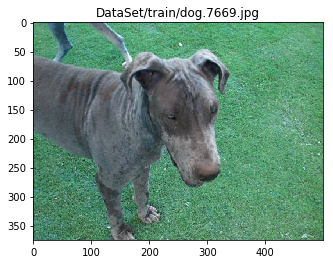

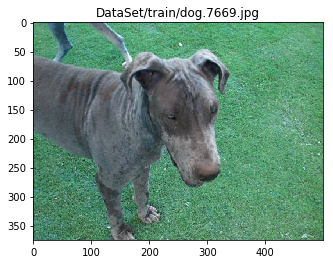

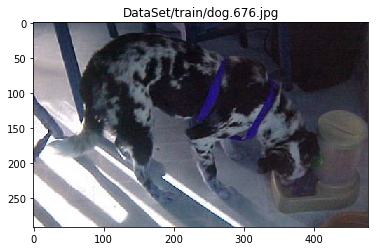

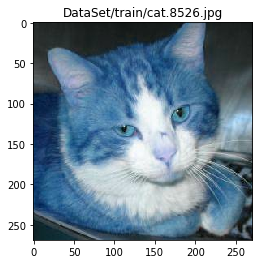

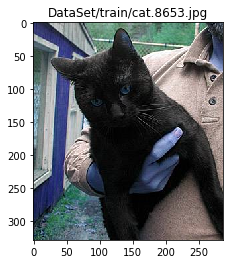

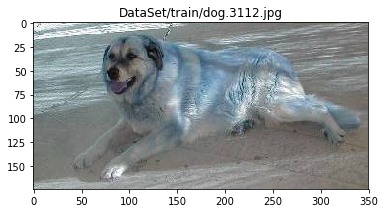

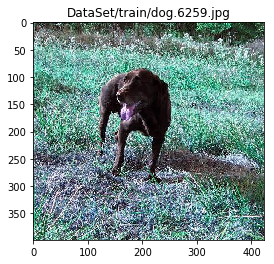

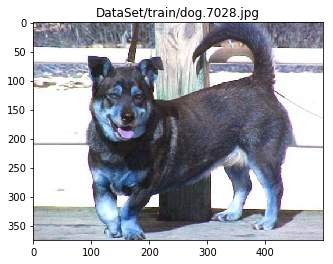

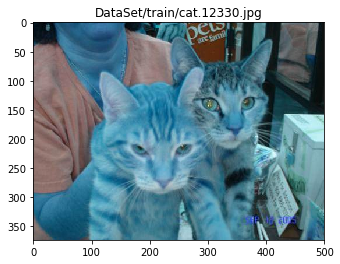

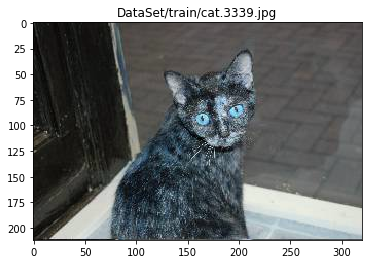

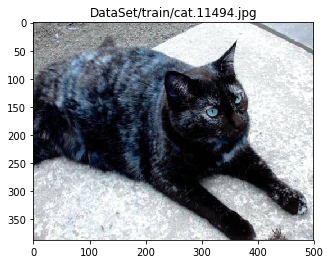

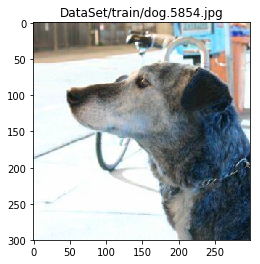

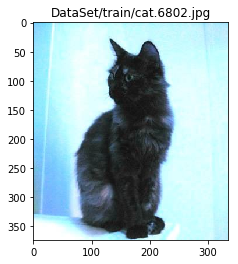

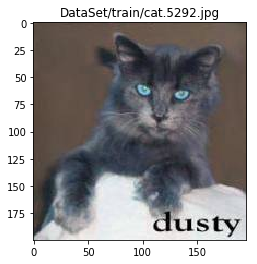

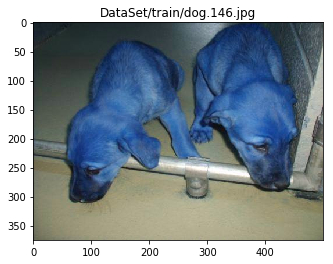

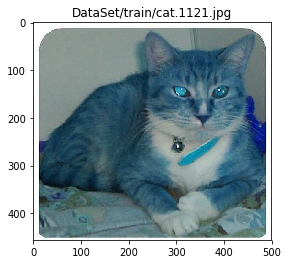

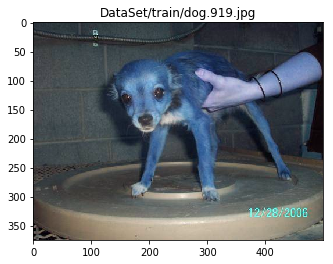

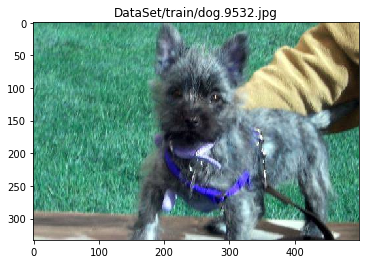

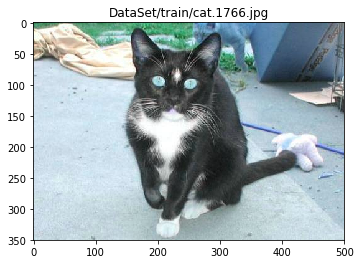

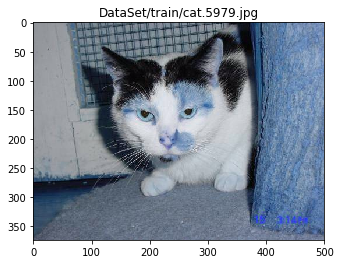

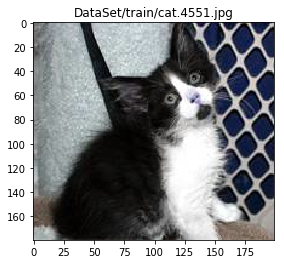

In [7]:
# 从train目录下获取指定数目的随机数据指针(图片的文件名)
def get_randlist(sdir, count = 20):
    flist = os.listdir(sdir)
    slist = []
    count = count
    while count > 0:
        item = choice(flist)
        slist.append(item)
        flist.remove(item)
        count -= 1

    return(slist)

# 图片显示
def show_pic(fp):
    img = cv2.imread(fp)
    plt.imshow(img)
    plt.axis('on')
    plt.title(fp)
    plt.show()

show_list = [ '{}/{}'.format(TRAIN_DIR, x) for x in get_randlist(TRAIN_DIR) ]
show_pic(show_list[0])
for fp in show_list:
    show_pic(fp)

-   可以发现, 有些图片中的猫狗比例非常小, 甚至于非常模糊, 或者图片中压根就没有包含猫狗
-   接着看看图片尺寸的分布情况

In [8]:
# 获取所有图片的尺寸
def get_shape():
    flist = os.listdir(TRAIN_DIR)
    flist = [ '{}/{}'.format(TRAIN_DIR, x) for x in flist ]
    shape_list = []
    for fp in flist:
        img = cv2.imread(fp)
        shape_list.append([img.shape[0], img.shape[1]])
    return(shape_list)
                           
shape_list = get_shape()
X = [ s[0] for s in shape_list ]
Y = [ s[1] for s in shape_list ]

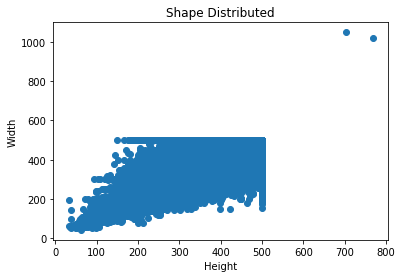

In [9]:
# 绘制散点图
plt.scatter(X, Y)
plt.title('Shape Distributed')
plt.xlabel('Height')
plt.ylabel('Width')
plt.show()

-   通过上图可以发现, 图片的尺寸是大小不一的.
###   剔除异常数据
-   在异常值处理的时候, 难点不是在于删除, 而是确定哪些图片是异常值, 需要怎么确定.
-   手动剔除异常数据是非常不科学的, 在这里, 有几万张图片, 实际生产过程中甚至会接触到更多更大的数据集. 所以我们要尽量用机器帮我们处理一大部分的事务.
-   这里, 使用Xception预训练模型, 先对图片进行一个大致的判断, 然后再将筛选出来的少数图片人为审核一下. 如果没问题, 我们就将其作为一个列表送入删除函数, 将其文件彻底删除.

In [10]:
# 从github上下载已经整理好的ImageNet分类csv文件(这里只需要执行一次)
!git clone https://github.com/kylechenoO/ImageNetClasses.git

Cloning into 'ImageNetClasses'...
remote: Counting objects: 7, done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
Checking connectivity... done.


In [11]:
# 获取ImageNetClasses.csv文件中的猫狗分类列表
def get_rightClass(fp):
    rightClass = []
    with open(fp, 'r') as r:
        reader = csv.reader(r)
        for line in reader:
            if (line[1] == '猫') or (line[1] == '狗'):
                rightClass.append(line[0])
    return(rightClass)

# 读取图片数据
def read_img(fp, img_size):
    img = image.load_img(fp, target_size = img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return(x)

# 从目录中加载图片数据
def read_img_dir(flist, img_size):
    result = [ read_img(fp, img_size) for fp in tqdm(flist) ]
    return(result)

# 获取相关图片的预测结果
def get_predict(model, x, top = 10):
    pred = model.predict(x)
    return(decode_predictions(pred, top = top)[0])
    
# 获取所有图片预测结果
def get_predict_dir(model, X, top = 10):
    result = [ get_predict(model, x, top) for x in tqdm(X) ]
    return(result)

img_size = (299, 299, 3)
INClass_FP = 'ImageNetClasses/ImageNetClasses.csv'
flist = os.listdir(TRAIN_DIR)
flist = [ '{}/{}'.format(TRAIN_DIR, x) for x in flist ]
rightClass = get_rightClass(INClass_FP)
X = read_img_dir(flist, img_size)

# 注意, 这里一定要把Xception模型的定义给提取出来, 因为这一步需要一点时间
model = Xception(weights='imagenet')
pred = get_predict_dir(model, X, 50)

100%|██████████| 25000/25000 [06:41<00:00, 62.22it/s]


34


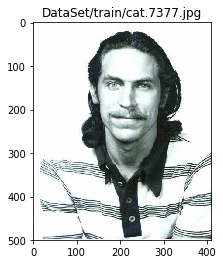

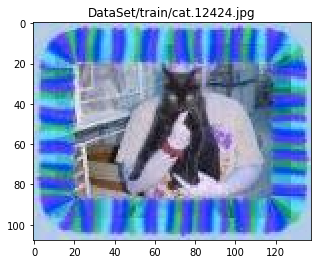

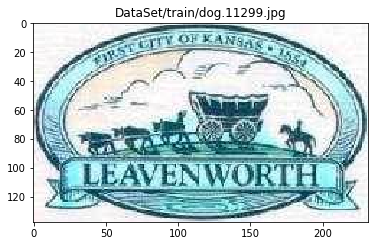

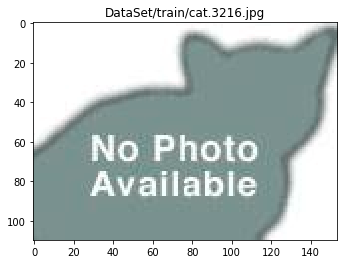

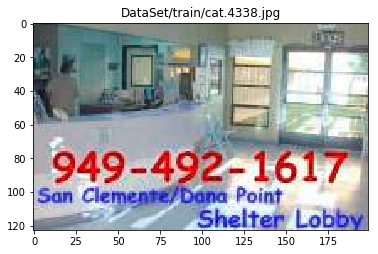

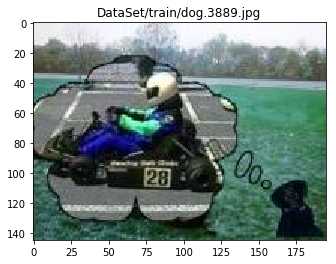

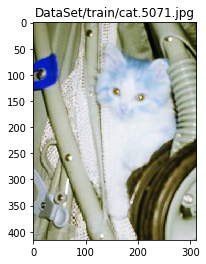

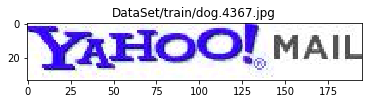

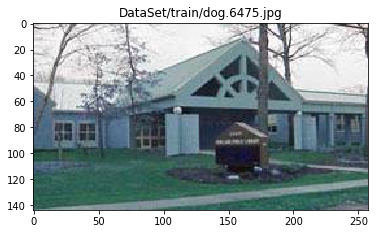

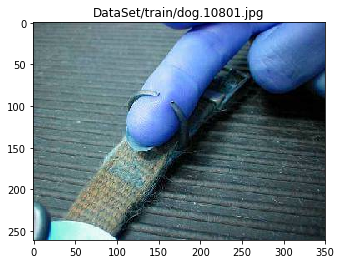

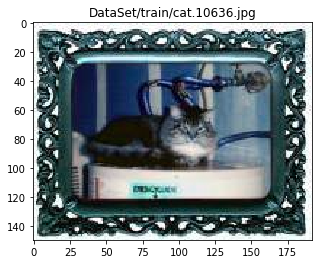

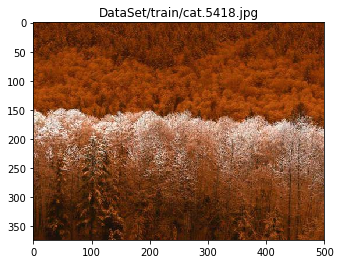

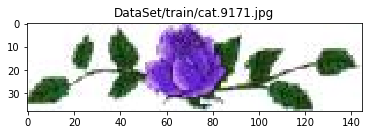

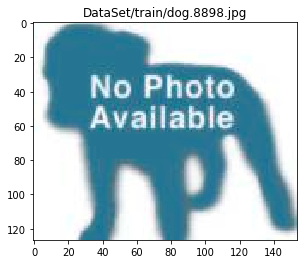

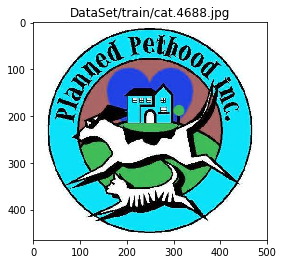

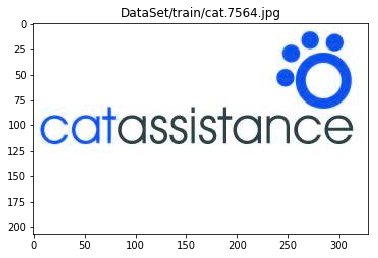

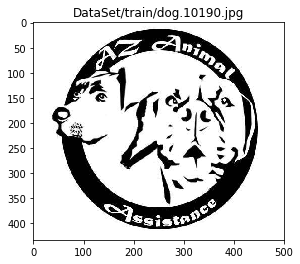

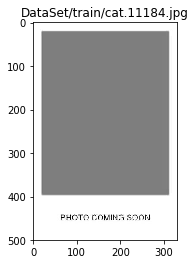

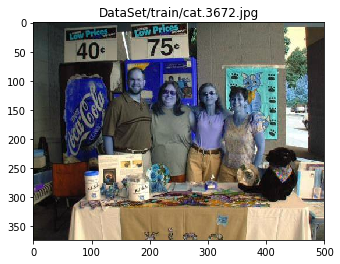

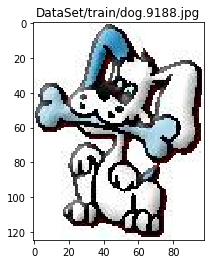

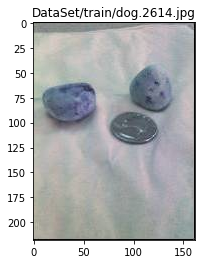

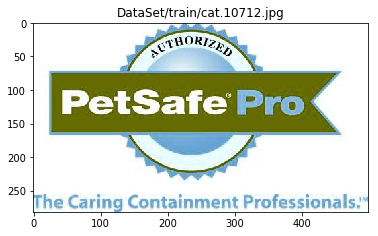

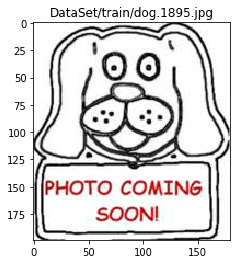

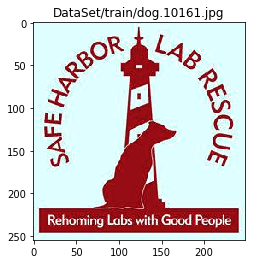

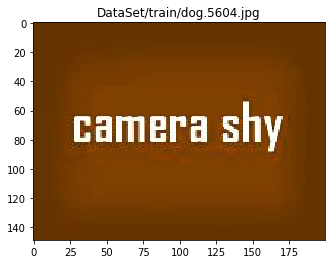

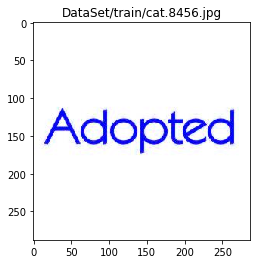

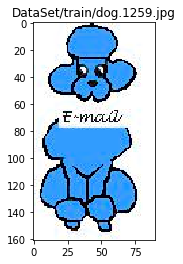

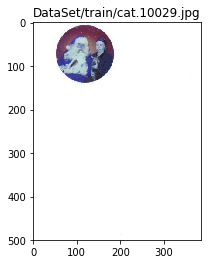

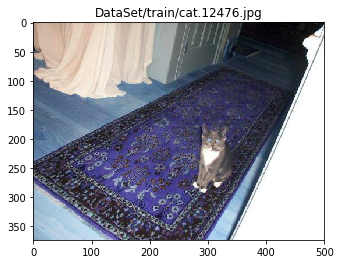

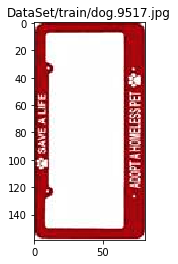

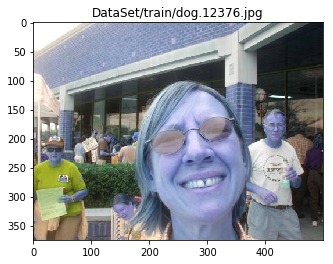

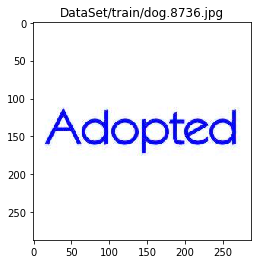

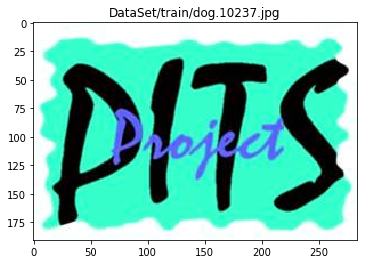

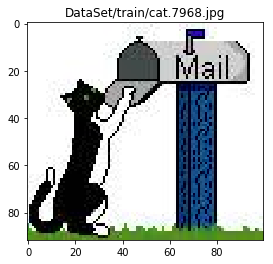

In [12]:
# 获取能match到猫狗类型的预测总数
def get_right_list(pred):
    right_list = []
    for item in pred:
        pred_list = [ x[0] for x in item ]
        pred_list = [ 1 for x in pred_list if x in rightClass ]
        right_list.append(sum(pred_list))
    return(right_list)

# 获取异常数据的文件名
right_list = get_right_list(pred)
exp_flist = []
for index, value in enumerate(right_list):
    if value == 0:
        exp_flist.append(flist[index])
        
# 看下一共有多少张异常图片
print(len(exp_flist))

# 将图片输出看看
for fp in exp_flist:
    show_pic(fp)

In [13]:
# 直接删除异常图片
for fp in exp_flist:
    os.remove(fp)

###   使用Xception导出特征权重
-   将train下的数据分类至transfer目录下, 便于后面导入图片数据.

In [14]:
# 将train下的数据分类并拷贝至transfer/train/{cat,dog}, test拷贝至DataSet/transfer/test/pic/目录下
!mkdir DataSet/transfer/train/cat -p
!mkdir DataSet/transfer/train/dog
!mkdir DataSet/transfer/test/pic -p
!find DataSet/train -name 'cat.*' -exec cp -rf {} DataSet/transfer/train/cat/ \;
!find DataSet/train -name 'dog.*' -exec cp -rf {} DataSet/transfer/train/dog/ \;
!find DataSet/test -name '*.jpg' -exec cp -rf {} DataSet/transfer/test/pic/ \;

-   加载数据

In [15]:
# run load data, change size to Xception default (299,299)
img_size = (299, 299)
gen = ImageDataGenerator()
X_train_gen = gen.flow_from_directory(TRANSFER_TRAIN_DIR, img_size, shuffle = False, 
                                        batch_size = 16)
X_test_gen = gen.flow_from_directory(TRANSFER_TEST_DIR, img_size, shuffle = False, 
                                        batch_size = 16, classes = None)

Found 24966 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


-   训练模型设计

In [16]:
input_tensor = Input((img_size[0], img_size[1], 3))
input_tensor = Lambda(xception.preprocess_input)(input_tensor)
Xception_base = Xception(input_tensor = input_tensor, 
                             weights = 'imagenet', include_top = False)
Xception_model = Model(Xception_base.input, GlobalAveragePooling2D()(Xception_base.output))
Xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

-   利用Xception训练特征向量

In [17]:
X_train = Xception_model.predict_generator(X_train_gen, verbose = 1)
X_test = Xception_model.predict_generator(X_test_gen, verbose = 1)

782/782 [==============================] - 91s 116ms/step


-   保存特征权重

In [18]:
with h5py.File('saved_models/weights.Xception.hdf5') as fp:
        fp.create_dataset('train', data = X_train)
        fp.create_dataset('test', data = X_test)
        fp.create_dataset('label', data = X_train_gen.classes)

-   导入我们刚刚训练好的特征向量

In [19]:
X_train = []
X_test = []
with h5py.File('saved_models/weights.Xception.hdf5', 'r') as fp:
    X_train.append(np.array(fp['train']))
    X_test.append(np.array(fp['test']))
    y_train = np.array(fp['label'])
    
X_train = np.concatenate(X_train, axis = 1)
X_test = np.concatenate(X_test, axis = 1)
X_train, y_train = shuffle(X_train, y_train)

-   针对不同的Droupout参数进行尝试

In [34]:
# 定义一个函数来尝试不同的Dropout
def try_dropout(X, y, start = 0.1, end = 0.9, step = 0.1):
    r = start
    epochs = 10
    batch_size = 128
    rg_list = []
    ls_list = []
    ac_list = []
    r = start
    while r <= end:
        input_tensor = Input(X_train.shape[1:])
        Xception_model = Model(input_tensor, Dropout(r)(input_tensor))
        Xception_model = Model(Xception_model.input, Dense(1, activation = 'sigmoid')(Xception_model.output))
        
        Xception_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
        hist_Xception = Xception_model.fit(X_train, y_train, validation_split = 0.3,
                            epochs = epochs, batch_size = batch_size, verbose = 1)
        
        rg_list.append(round(r, 1))
        ls_list.append(hist_Xception.history['val_loss'])
        ac_list.append(hist_Xception.history['val_acc'])
        r += step
        
    return(rg_list, ls_list, ac_list)
        
rg_list, ls_list, ac_list = try_dropout(X_train, y_train)

Train on 17476 samples, validate on 7490 samples
Epoch 1/10
17476/17476 [==============================] - 2s 108us/step - loss: 0.1480 - acc: 0.9784 - val_loss: 0.0508 - val_acc: 0.9925
Epoch 2/10
17476/17476 [==============================] - 1s 32us/step - loss: 0.0359 - acc: 0.9927 - val_loss: 0.0276 - val_acc: 0.9933
Epoch 3/10
17476/17476 [==============================] - 1s 32us/step - loss: 0.0240 - acc: 0.9936 - val_loss: 0.0232 - val_acc: 0.9931
Epoch 4/10
17476/17476 [==============================] - 1s 32us/step - loss: 0.0200 - acc: 0.9942 - val_loss: 0.0199 - val_acc: 0.9936
Epoch 5/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0184 - acc: 0.9946 - val_loss: 0.0188 - val_acc: 0.9940
Epoch 6/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0171 - acc: 0.9954 - val_loss: 0.0179 - val_acc: 0.9944
Epoch 7/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0165 - acc: 0.9954 - val_loss: 0.0178 - val_acc

17476/17476 [==============================] - 1s 33us/step - loss: 0.0211 - acc: 0.9941 - val_loss: 0.0184 - val_acc: 0.9940
Epoch 9/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0202 - acc: 0.9944 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 10/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0197 - acc: 0.9942 - val_loss: 0.0176 - val_acc: 0.9940
Train on 17476 samples, validate on 7490 samples
Epoch 1/10
17476/17476 [==============================] - 2s 111us/step - loss: 0.1690 - acc: 0.9661 - val_loss: 0.0552 - val_acc: 0.9924
Epoch 2/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0482 - acc: 0.9904 - val_loss: 0.0312 - val_acc: 0.9927
Epoch 3/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0333 - acc: 0.9922 - val_loss: 0.0244 - val_acc: 0.9935
Epoch 4/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0282 - acc: 0.9927 - val_loss: 0.0224 - val_acc: 0.9932
E

-   可视化结果

Dropout	|	Avg			|	Min			|	Max
0.1	|	0.02282901411573309	|	0.01688006311960926	|	0.050759713903805605
0.2	|	0.02281407362205139	|	0.01706479162615643	|	0.049888258058334065
0.3	|	0.022982535592929395	|	0.01713491020791322	|	0.05133768478644706
0.4	|	0.022974584958483736	|	0.01726240441339894	|	0.05013868906528991
0.5	|	0.023677595540177378	|	0.017503379824296516	|	0.05315908531997805
0.6	|	0.024609190419873347	|	0.01758514096729149	|	0.055413433173310774
0.7	|	0.024861933534351913	|	0.018181112068375756	|	0.05519711386675987
0.8	|	0.027546480498158527	|	0.019060999181902457	|	0.06209147023223589
0.9	|	0.03105263900213212	|	0.021897574044386043	|	0.06908809482772774


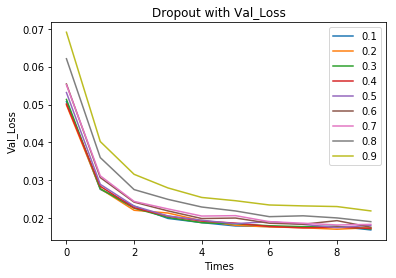

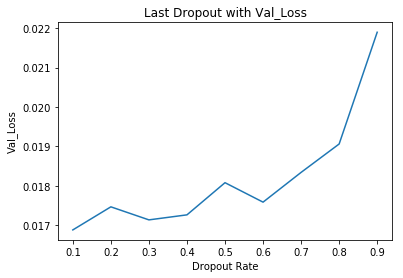

In [35]:
# val_loss学习曲线
color_list = ['tab:blue', 'tab:orange', 'tab:green', \
                  'tab:red', 'tab:purple', 'tab:brown', \
                  'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
print('Dropout\t|\tAvg\t\t\t|\tMin\t\t\t|\tMax')
for i in range(len(ls_list)):
    plt.plot(ls_list[i], color = color_list[i], label = rg_list[i])
    print('{}\t|\t{}\t|\t{}\t|\t{}'.format(rg_list[i], \
            sum(ls_list[i]) / len(ls_list[i]), min(ls_list[i]), max(ls_list[i])))
    
# plot Times/Val_Loss
plt.title('Dropout with Val_Loss')
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.legend()
plt.show()

# plot Dropout/Val_Loss
plt.plot(rg_list, [ x[-1:] for x in ls_list ])
plt.title('Last Dropout with Val_Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Val_Loss')
plt.show()

Dropout	|	Avg			|	Min			|	Max
0.1	|	0.9936982643524701	|	0.9925233644859813	|	0.9945260347129506
0.2	|	0.9935647530040053	|	0.9919893190921228	|	0.994392523364486
0.3	|	0.9936715620827771	|	0.9927903871829106	|	0.9942590120160214
0.4	|	0.9936715620827771	|	0.9922563417890521	|	0.9946595460614153
0.5	|	0.9935246995994659	|	0.9921228304405875	|	0.9942590120160214
0.6	|	0.9933110814419225	|	0.9913217623497997	|	0.9939919893190922
0.7	|	0.9933911882510014	|	0.9923898531375167	|	0.9939919893190922
0.8	|	0.9926568758344461	|	0.9902536715620828	|	0.9934579439252337
0.9	|	0.9927503337783714	|	0.9909212283044059	|	0.9933244325767691


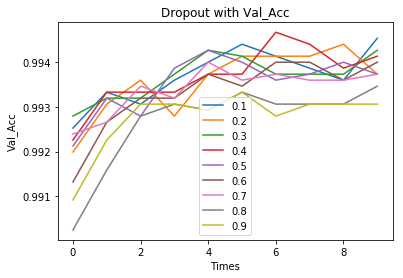

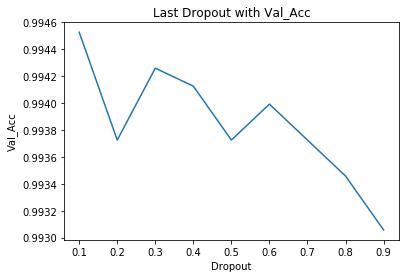

In [36]:
# val_acc学习曲线
print('Dropout\t|\tAvg\t\t\t|\tMin\t\t\t|\tMax')
for i in range(len(ls_list)):
    plt.plot(ac_list[i], color = color_list[i], label = round(rg_list[i], 1))
    print('{}\t|\t{}\t|\t{}\t|\t{}'.format(rg_list[i], \
            sum(ac_list[i]) / len(ac_list[i]), min(ac_list[i]), max(ac_list[i])))
    
# plot Times/Val_Acc
plt.title('Dropout with Val_Acc')
plt.xlabel('Times')
plt.ylabel('Val_Acc')
plt.legend()
plt.show()

# plot Last Dropout/Val_Acc
plt.plot(rg_list, [ x[-1:] for x in ac_list ])
plt.title('Last Dropout with Val_Acc')
plt.xlabel('Dropout')
plt.ylabel('Val_Acc')
plt.show()

-   选取上一步最好的Dropout参数(这里选取0.3, 主要看最低的val_loss), 使用Xception训练好的特征向量构建模型

In [23]:
input_tensor = Input(X_train.shape[1:])
Xception_model = Model(input_tensor, Dropout(0.3)(input_tensor))
Xception_model = Model(Xception_model.input, Dense(1, activation = 'sigmoid')(Xception_model.output))
Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


-   编译模型

In [24]:
Xception_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

-   使用Xception训练模型

In [25]:
epochs = 10
batch_size = 128
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                                   verbose=1, save_best_only=True)
hist_Xception = Xception_model.fit(X_train, y_train, validation_split = 0.3,
                    epochs = epochs, batch_size = batch_size, verbose=1,
                    callbacks=[checkpointer])

Train on 17476 samples, validate on 7490 samples
Epoch 1/10
17476/17476 [==============================] - 2s 93us/step - loss: 0.1507 - acc: 0.9771 - val_loss: 0.0514 - val_acc: 0.9927

Epoch 00001: val_loss improved from inf to 0.05137, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0385 - acc: 0.9926 - val_loss: 0.0280 - val_acc: 0.9935

Epoch 00002: val_loss improved from 0.05137 to 0.02796, saving model to saved_models/weights.best.Xception.hdf5
Epoch 3/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0260 - acc: 0.9932 - val_loss: 0.0222 - val_acc: 0.9933

Epoch 00003: val_loss improved from 0.02796 to 0.02221, saving model to saved_models/weights.best.Xception.hdf5
Epoch 4/10
17476/17476 [==============================] - 1s 33us/step - loss: 0.0215 - acc: 0.9940 - val_loss: 0.0203 - val_acc: 0.9932

Epoch 00004: val_loss improved from 0.02221 to 0.02025, saving mode

-   学习曲线

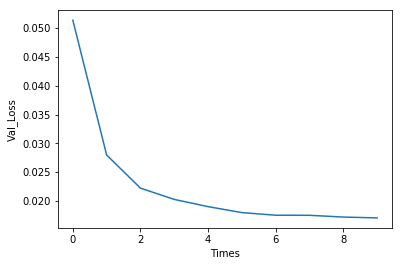

In [26]:
# val_loss学习曲线
plt.plot(hist_Xception.history['val_loss'])
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.show()

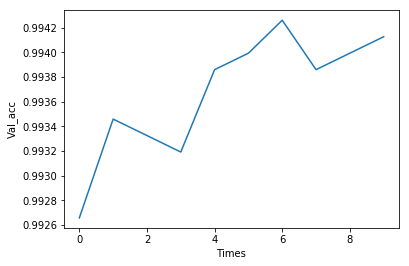

In [27]:
# val_loss学习曲线
plt.plot(hist_Xception.history['val_acc'])
plt.xlabel('Times')
plt.ylabel('Val_acc')
plt.show()

-   可以发现, 模型表现还不错.
###   尝试往kaggle上提交


-   对测试集进行预测

In [28]:
y_test = Xception_model.predict(X_test)
y_test = y_test.clip(min = 0.005, max = 0.995)

-   保存数据

In [29]:
num = [ int(re.sub('.jpg', '', re.sub('.*\/', '', f))) for f in X_test_gen.filenames ]
df = pd.read_csv(RESULT_SAMP)
for i in range(len(num)):
    df.set_value(num[i] - 1, 'label', y_test[i])
df.to_csv(RESULT_FILE, index=None)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


###   展示一些模型的分类结果

[11418, 5041, 5119, 7707, 10160]


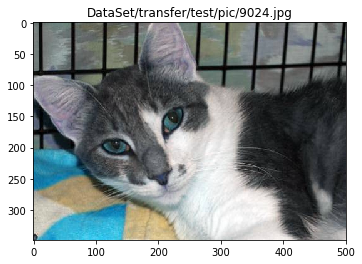

[0.005]


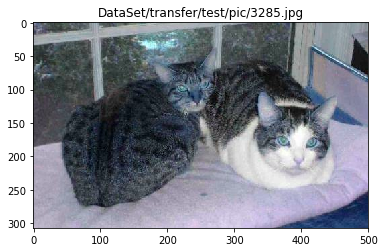

[0.005]


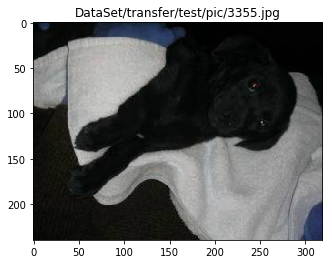

[0.98196983]


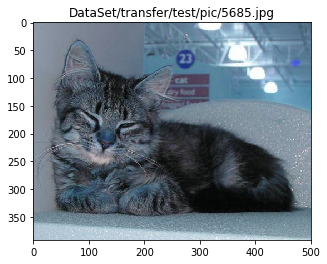

[0.005]


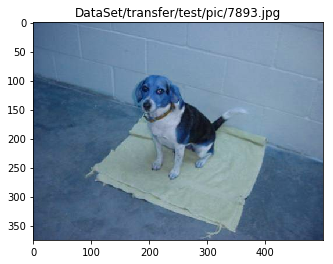

[0.995]


In [30]:
# show_pic(X_test_gen.filenames[0])
rp_list = [ '{}/{}'.format(TRANSFER_TEST_DIR, f) for f in X_test_gen.filenames ]
id_list = []
while len(id_list) < 5:
    val = random.randint(0, len(rp_list))
    if val not in id_list:
        id_list.append(val)
        
print(id_list)
for i in id_list:
    show_pic(rp_list[i])
    print(y_test[i])